<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/create_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####  Referencias

* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)
* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)

####  Ejemplos

* [Ejemplo word2vect](https://colab.research.google.com/drive/1YcplHjDL1M6G9K62W4GyUbic0OxOt8GZ?usp=sharing)
* [Ejemplo carga de dataset](https://colab.research.google.com/drive/1Qlq56GM6xERVpy6FAJhS5XCqaAKGlGtD?usp=sharing)
* [Análisis de Redes 1](https://colab.research.google.com/drive/1ef-fnqmPsAxqlIc_ZrBXa0Fg6IYYf_g_?usp=sharing)
* [Análisis de Redes 2](https://colab.research.google.com/drive/1IaIreaEvIXiOq0gmjYJw7Q1y9lhY20ZM?usp=sharing#scrollTo=4v-e0C44llje)

In [1]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [2]:
if is_runing_into_colab_env(): 
    !pip install rich
    !pip install networkx

In [3]:
%matplotlib inline
%load_ext autoreload
%load_ext rich
%autoreload 2

###  2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/datasets`.

In [4]:
dataset_filename = "SWOW-EN.R100.csv"
embeding_filename = "glove.840B.300d"
embeding_filename_txt = embeding_filename + '.txt'

dataset_url  = 'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp2/main/datasets/{}.zip'.format(dataset_filename)
embeding_url = 'https://nlp.stanford.edu/data/{}.zip'.format(embeding_filename)

if is_runing_into_colab_env():
    !cd ~
    !rm -rf datasets
    !rm -rf *.zip
    !wget  {dataset_url}
    !wget  {embeding_url}
    !unzip {dataset_filename}.zip
    !unzip {embeding_filename}.zip
    !mkdir datasets
    !mv {dataset_filename} datasets
    !mv {embeding_filename}.txt datasets
    !rm *.zip

###  3. Importa libreria del proyecto

In [5]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [6]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  4. Importa paquetes externos

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx

import logging
from logger import setup_logger

from scipy.spatial.distance import euclidean, jaccard, cosine
from distance import closest, show_closest, distance

from step import  select_columns, \
                  rename_columns, \
                  filter_bidiredtional_associations, \
                  filter_words_lt, \
                  filter_stopwords, \
                  to_unique_works, \
                  to_work_embeddings, \
                  lower, \
                  strip, \
                  dropna, \
                  plot_frequency, \
                  log_unique_words, \
                  log_source_into_response_and_vise_versa, \
                  n_top, \
                  all_columns_contains, \
                  append_distance


from graph import graph_summary, \
                  graph_edges, \
                  plot_edge_weight_hist

[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
setup_logger(format = '%(levelname)s: %(message)s')

###  5. Preprocesar dataset

En este paso seleccionamos las columnas **cue** y **R1**, las renombramos a **source** y **response**. Luego minisculizamos y quitamos espacios. Filtramos las palabras de menos de 2 letras, filtramos las filas con nulos. Por último filtramos stop words por varios lenguajes.

In [9]:
def load_dataset(filename): return pd.read_csv(dataset_path.format(filename))

In [10]:
dataset = load_dataset(dataset_filename) \
    .pipe(select_columns) \
    .pipe(rename_columns, {'cue': 'source', 'R1': 'response'}) \
    .pipe(lower) \
    .pipe(strip) \
    .pipe(log_unique_words) \
    .pipe(log_source_into_response_and_vise_versa, unique=True) \
    .pipe(log_source_into_response_and_vise_versa, unique=False) \
    .pipe(filter_words_lt, size_less_than=2) \
    .pipe(dropna) \
    .pipe(filter_stopwords, column = 'source') \
    .pipe(filter_stopwords, column = 'response')

INFO: (1228200, 13) --> select_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> rename_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> lower({}) --> (1228200, 2)
INFO: (1228200, 2) --> strip({}) --> (1228200, 2)
INFO: Unique - Source: 12282, Response: 63715
INFO: Unique: True, Source into response: 1104304, Response into source: 1219500
INFO: Unique: False, Source into response: 123896, Response into source: 8700
INFO: (1228200, 2) --> filter_words_lt({'size_less_than': 2}) --> (1225128, 2)
INFO: (1225128, 2) --> dropna({}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['arabic']}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['azerbaijani']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['bengali']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['danish']}) --> (1191959, 2)
INFO: (1191959, 2) --> filter_stopwords({'languages': ['dutch']}) --> (1190828, 2)
INFO: (1190828, 2) --

###  6. Generar un dicionario de embedding a partir de Glove

A continuacion se genera un diccionario donde la calse es una palabra y el valor es un vector embedding. Ademas solo genermos este doccionario para las palabar que se encuentran en el dataset inicial.

In [11]:
work_embeddings = dataset \
    .pipe(to_unique_works) \
    .pipe(to_work_embeddings, file_path = dataset_path.format(embeding_filename_txt))

INFO: (1135308, 2) --> to_unique_works({}) --> (462916, 1)


  0%|          | 0/462916 [00:00<?, ?it/s]

INFO: Found 5709 words.
INFO: (462916, 1) --> to_work_embeddings({'file_path': '../datasets/glove.840B.300d.txt'}) --> 5709


Finalmente filtramos el dataset para que tengo solamante palabras que existan en el embeding, nos quedamos con las filas para las cuales exista su par (Para (a, b) existe un par (b,a)). Finalmente se grafica la frecuencia de palabras para cada columna. 

INFO: (1843, 2) --> filter_bidiredtional_associations({}) --> (1223, 2)


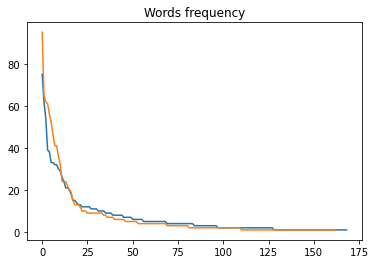

In [12]:
dataset = dataset \
    .pipe(all_columns_contains, words = work_embeddings.keys()) \
    .pipe(filter_bidiredtional_associations) \
    .pipe(plot_frequency, column = 'source') \
    .pipe(plot_frequency, column = 'response')

In [13]:
dataset.shape

(1223, 2)

### 7. Calcular distancias

Calculamos la distancias de una palabra elegida al azar contra todas las demas palabras del diccionario. Luego nos quedamos con el top 10 de las palabras mas cercanas.

In [14]:
any_word = list(work_embeddings.keys())[10]
any_word2 = list(work_embeddings.keys())[11]

show_closest(work_embeddings, any_word, cosine)
show_closest(work_embeddings, any_word, euclidean)
show_closest(work_embeddings, any_word, jaccard)

INFO: - distance: cosine
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'affordable', 'straightforward', 'mainstream', 'sustainable', 'regardless', 'marketplace', 'framework', 'guidelines']
INFO: - distance: euclidean
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'straightforward', 'regardless', 'affordable', 'mainstream', 'mainstay', 'drawback', 'forefront', 'alongside']
INFO: - distance: jaccard
INFO: - Word: alternative
INFO: - Closest: ['jetliner', 'dealbreaker', 'goldeneye', 'shipmate', 'penknife', 'masterbedroom', 'stairstep', 'serverfarm', 'website']


In [15]:
distance(work_embeddings, any_word, any_word2, euclidean)

8.361441612243652

### 8. Tareas

#### Tarea 1: Construcción de los grafos

A continacion tomamos por un lado **dataset** (el cual tiene las columnas pregunta y respuesta) y por el otro el diccionario de **word_embeddings** y finalmente convertimos ambos datasets en grafos.

Creamos un dataset pesado por la distancia coseno entre las palabras fitlradas desde **Small World of Words**:

In [16]:
dataset = dataset \
    .pipe(append_distance, work_embeddings, cosine) \
    .pipe(rename_columns, {'cosine': 'weight'})

dataset

INFO: (1223, 3) --> append_distance({}) --> (1223, 3)
INFO: (1223, 3) --> rename_columns({}) --> (1223, 3)


,source,response,weight
30,sunday,sunday,0.000000
4110,sunday,sunday,0.000000
15865,photograph,snapshot,0.602729
21283,sunday,homework,0.596469
50440,photograph,snapshot,0.602729
...,...,...,...
1224286,boyfriend,girlfriend,0.141456
1224290,daytime,nighttime,0.222926
1226049,database,spreadsheet,0.481167
1227088,trademark,copyright,0.495920


Creamos un grafo pesado:

In [17]:
weighted_graph = nx.from_pandas_edgelist(dataset, 'source',  'response', 'weight', create_using=nx.Graph())

Graph with 180 nodes and 237 edges
Es pesado?  Si
Es Dirigido?  No
Tiene ciclos?  Si
Tiene multiples aristas?  No


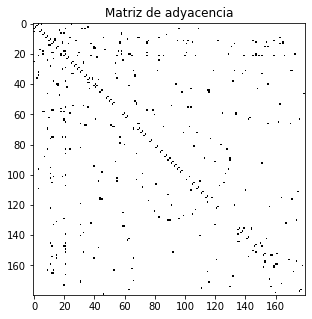

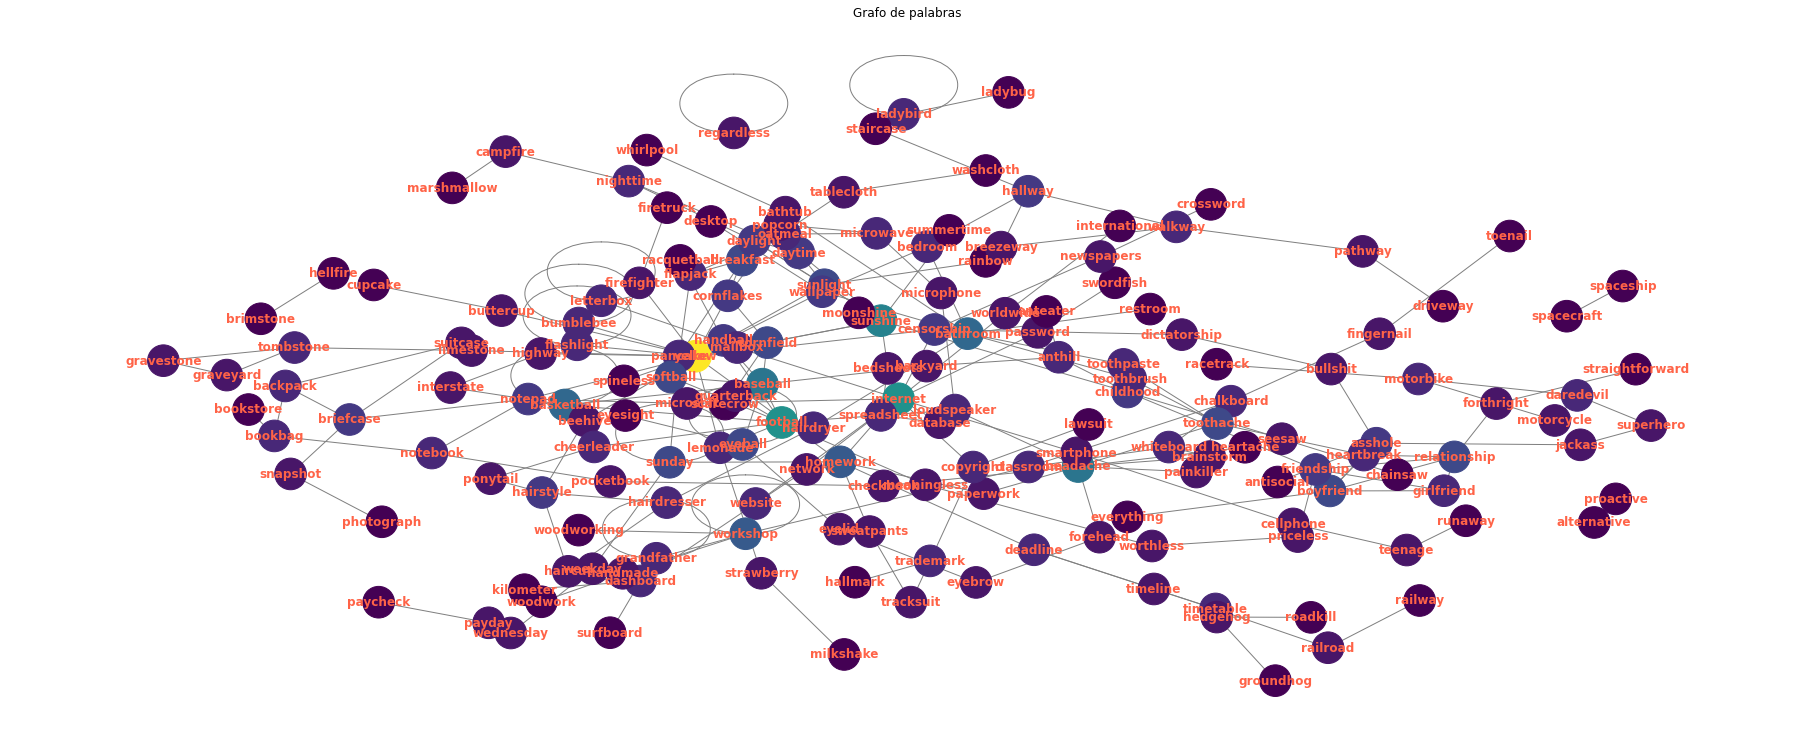

In [30]:
graph_summary(weighted_graph)

Creamos un grafo de interaccion, es decir no pesado:

In [31]:
interaction_graph = nx.from_pandas_edgelist(dataset, 'source',  'response', create_using=nx.Graph())

Graph with 180 nodes and 237 edges
Es pesado?  No
Es Dirigido?  No
Tiene ciclos?  Si
Tiene multiples aristas?  No


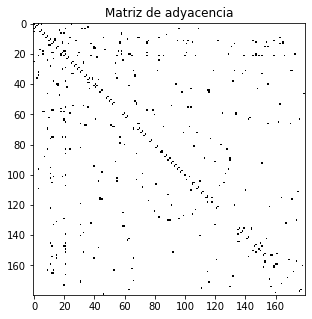

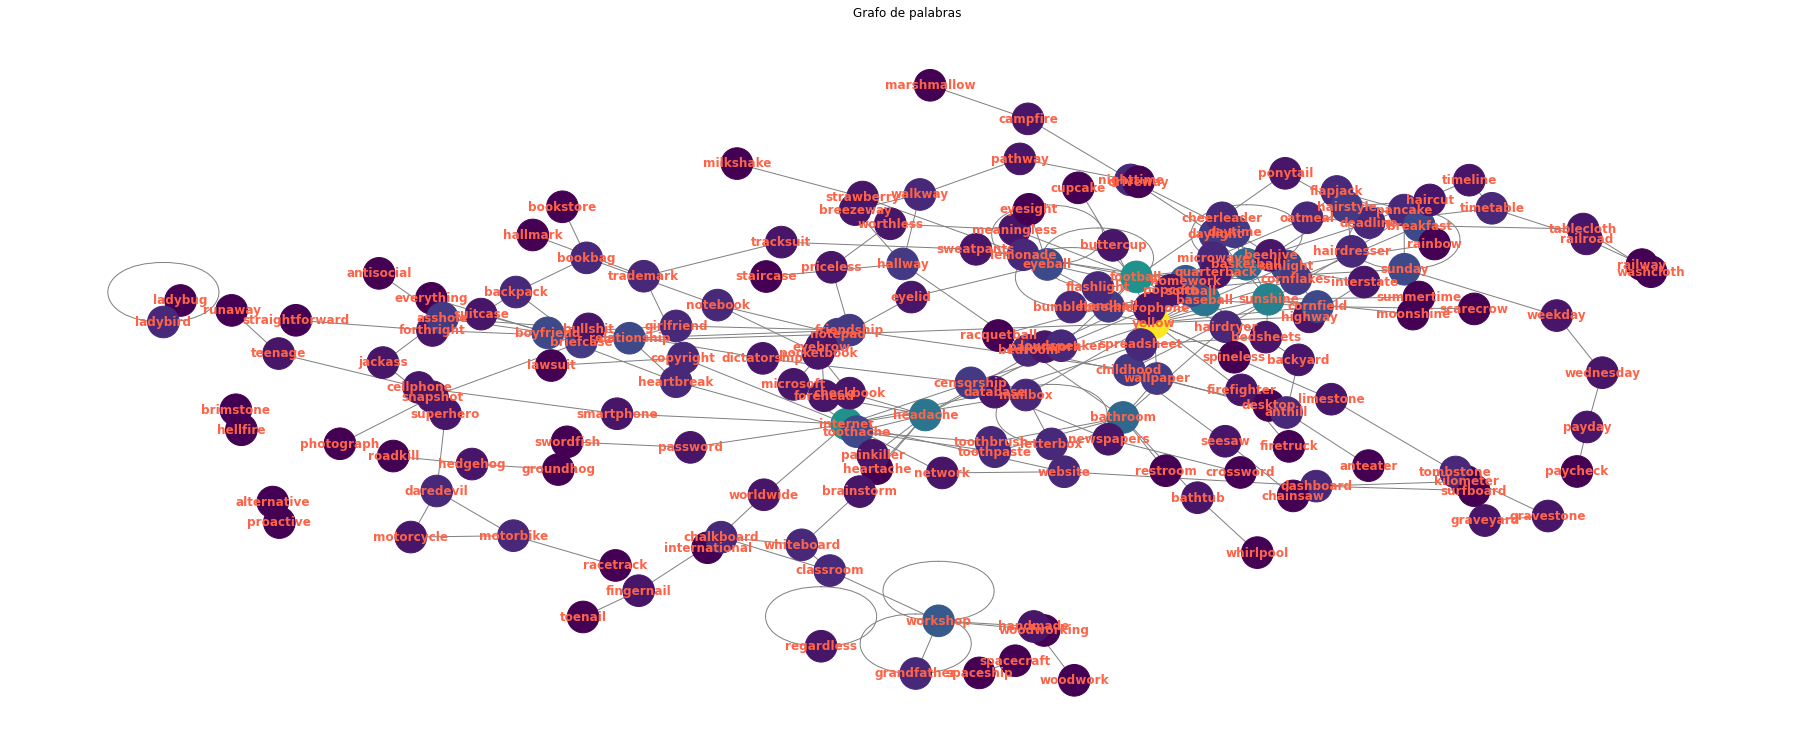

In [32]:
graph_summary(interaction_graph)

#### Tarea 2: Carácterización de los grafos

Comparar los dos grafos en terminos de medidas de cliques/clustering, distintas medidas de centralidad3, distribución de pesos, distribución de grado, asortatividad, camino mínimo, diámetro, etc. ¿Qué pueden decir de cada uno de los grafos? ¿Y qué pueden decir de la comparación entre ellos?

**Opcional 1**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado?

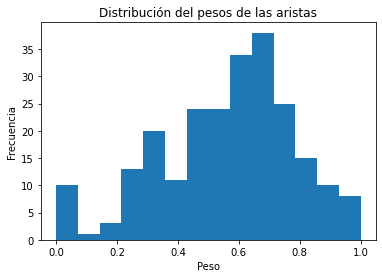

In [35]:
plot_edge_weight_hist(weighted_graph)

#### Tarea 3: Comunidades

Detectar comunidades en Gsww y Gw2v con el algoritmo que consideren más indicado, justificar por qué. Calcular el indice de modularidad en cada caso ¿Qué pueden decir de las comunidades?
Comparar las comunidades de ambas redes con el índice rand (u otra métrica que considere adecuada) ¿Son similares?
Visualizar uno de los grafos, y pintarlo según las comunidades del otro ¿Qué se puede decir?
También se puede analizar la resolución del algoritmo de por el cuál se detectan las comunidades. Para ello, pueden explorar estructuras dentro de alguna de las comunidades.

* **Opcional 2**: Utilizar distintos algoritmos y comparar los resultados.
* **Opcional 3**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado? ¿Y para Gw2v?
* **Opcional 4**: Utilizar algoritmos de reducción de dimensionalidad como MDS, tSNE, o UMAP para ubicar las palabras en dos dimensiones y pintar según las comunidades identificadas. Se puede elegir un subconjunto de palabras para que sea más claro. También pueden proyectar en el espacio construido con word2vec y pintar según las comunidades identificadas en Gsww, o viceversa.

COMPLETAR

#### Tarea 4: Small-world y redes prototípicas

Existen trabajos previos que muestran que tanto la red de asociaciones (Gsww) como la red semántica (Gw2v) tienen estructura de small-world [5, 6]. Comparar las características de redes, como el camino mínimo, con distintos modelos de redes, en particular con redes small-world. Para ello generar N redes small-world con el mismo número de nodos y aristas, y evaluar si las características medidas en Gsww y Gw2v podrían pertenecer a dichas distribuciones.

* **Opcional 4**: Además de realizar esta tarea con el small-world, repetirlo con las random o scale-free.

COMPLETAR